## Problem description


The heater equation ("Heizkörpergleichung") contains several subterms (fractions, logarithms) which have singularities. Thus, a direct implementation of this equation might lead to numerical errors during simulation.

## Solution proposal

The equation should be evaluated only for a restricted subset of $\mathbb{R}^3$ (arguments $\Theta_\mathrm{R}, \Theta_\mathrm{V}, \Theta_\mathrm{int}$). This set can be defined by inequalities like
$$
\Theta_\mathrm{R} < \Theta_\mathrm{V}\\
\Theta_\mathrm{int} < \Theta_\mathrm{R}\\
...
$$

Outside of this set, the transmitted power is 0 for physical reasons.

Additionally, to avoid discontinuous derivatives, the piecewise defined function is multiplied by a smoothness factor. This might be beneficial for using the heat equation inside numerical algorithms (simulation, optimization).

In [1]:
import time
print(time.ctime())

Tue Nov 23 12:15:55 2021


In [2]:
import numpy as np
import math
from matplotlib import pyplot as plt

In [3]:
def func(Theta_R, Theta_int):
    """
    evaluation of the critical expression with vectorized case distinction
    """
    
    
    Theta_V = 360 # this is fixed here for easier plotting
    
    # ensure that arguments are always arrays
    Theta_R = np.atleast_1d(Theta_R)
    Theta_int = np.atleast_1d(Theta_int)
    
    
    # create an boolean array, which is True (≙ 1) where the expression can be meaningfully evaluated 
    # and False (≙ 0) elsewhere
    # This array will be used for indexing later. idcs ≙ "indices"
    idcs = (Theta_R > Theta_int)*(Theta_R > Theta_int)
    
    
    # the result array should contain 0 as default
    res1 = Theta_R*0
    
    # restrict the arguments to allowed combinations by applying the boolean index-array
    # see https://numpy.org/doc/stable/user/basics.indexing.html#boolean-or-mask-index-arrays
    Theta_R = Theta_R[idcs]
    Theta_int = Theta_int[idcs]
    
    
    # overwrite some default-zeros at the allowed "locations" (indices)
    # note: the critical expression is only evaluated with uncritical arguments
    res1[idcs] = (Theta_V - Theta_R) / (np.log(Theta_V - Theta_int) - np.log(Theta_R - Theta_int))
    
    # return the full array
    return res1



def func_smooth(Theta_R, Theta_int, k_smooth=1):
    """
    evaluation of the critical expression with vectorized case distinction (same as above),
    but with some additional smoothness-factor,
    such that it probably behaves better in numeric simulations
    """
    
    
    Theta_V = 360
    
    

    Theta_R = np.atleast_1d(Theta_R)
    Theta_int = np.atleast_1d(Theta_int)

    
    
    idcs = (Theta_R > Theta_int)*(Theta_V > Theta_R)
    # print(idcs)
    
    res1 = Theta_R*0
    
    Theta_R = Theta_R[idcs]
    Theta_int = Theta_int[idcs]
    
        
    # difference argument 
    delta = Theta_R - Theta_int
    
    # k_smooth: smoothness scaling factor
    
    # function which starts (for delta=0) at 0 with derivative also 0 and approaches 1 relatively fast
    # note that this function does not yield 0 as function value for delta < 0
    
    # however, this is achieved by the indexing mechanism anyway.
    
    smoothness_factor = (1 - np.exp(-k_smooth*delta**2))
    res1[idcs] = smoothness_factor*(Theta_V - Theta_R) / (np.log(Theta_V - Theta_int) - np.log(Theta_R - Theta_int))
    
    
    return res1



In [4]:
# this allows interactive zooming and rotating the 3d plot:
# %matplotlib qt

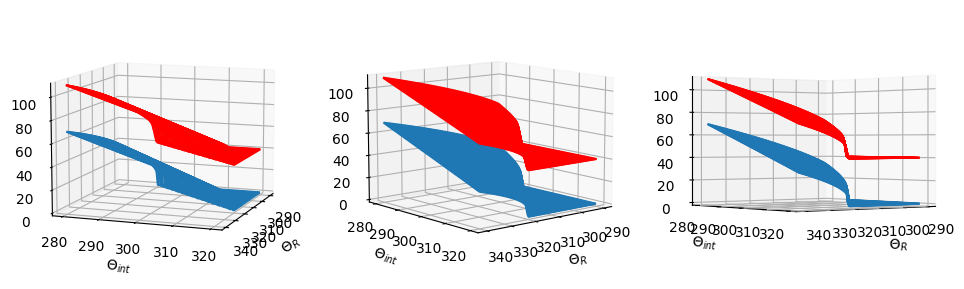

In [5]:
xx = np.linspace(290, 340, 100)
yy = np.linspace(280, 320, 100)

XX, YY = np.meshgrid(xx, yy)

ZZ = func(XX, YY)

mm = 1/25.4 # mm to inch
plt.figure(figsize=(300*mm, 100*mm), dpi=100)

azimutes = [ 20, 50, 52]
elevations = [ 10, 10, 0]

for i in range(len(azimutes)):
    ax1 = plt.subplot(1, len(azimutes), i+1, projection='3d')
    ax1.plot_wireframe(XX, YY, ZZ)
    ax1.plot_wireframe(XX, YY, func_smooth(XX, YY)+40, color="red")
    ax1.set_xlabel("$\Theta_R$")
    ax1.set_ylabel("$\Theta_{int}$")
    ax1.view_init(elev=elevations[i], azim=azimutes[i])
    



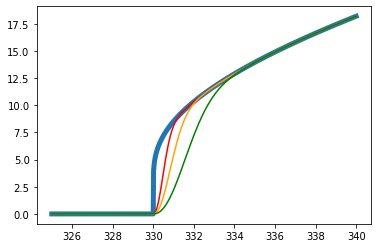

In [6]:
# 2D visualization of the critical range
tt = np.linspace(325, 340, 1000)

plt.plot(tt, func(Theta_R=tt, Theta_int=tt*0+330), lw=5)
plt.plot(tt, func_smooth(Theta_R=tt, Theta_int=tt*0+330, k_smooth=3), color="red")
plt.plot(tt, func_smooth(Theta_R=tt, Theta_int=tt*0+330, k_smooth=1), color="orange")
plt.plot(tt, func_smooth(Theta_R=tt, Theta_int=tt*0+330, k_smooth=0.3), color="green")